# Data Generation for Kura-Sivashinsky Equation

This notebook generates data for the Kura-Sivashinsky equation. The Kura-Sivashinsky equation is a partial differential equation that describes the evolution of a one-dimensional surface. It is given by

$$
\frac{\partial u}{\partial t} = -\nu \frac{\partial^2 u}{\partial x^2} - \frac{\partial u}{\partial x} - \frac{\partial^2 u}{\partial x^2} - \frac{\partial^4 u}{\partial x^4},
$$

where $u(x, t)$ is the surface height at position $x$ and time $t$, and $\nu$ is a positive constant. The Kuramoto-Sivashinsky equation is a nonlinear partial differential equation that exhibits chaotic behavior. It is used as a model for the dynamics of thin films and flame fronts.

ETDRK2 Method

The ETDRK2 method is a numerical method for solving partial differential equations. It is based on the exponential time differencing Runge-Kutta method. The ETDRK2 method is used to solve the Kura-Sivashinsky equation. The ETDRK2 method is a second-order method that is unconditionally stable. It is used to solve stiff partial differential equations.

The ETDRK2 method is based on the following steps:

1. Compute the linear part of the equation using the Fourier transform.
2. Compute the nonlinear part of the equation using the Fourier transform.
3. Compute the exponential time differencing Runge-Kutta method.
4. Compute the inverse Fourier transform to obtain the solution.

Advance first to an intermediate stage:

$$
u_{h}^{*} = e^{L \Delta t} u_{h}^{t} + \Delta t e^{L \Delta t / 2} N(u_{h}^{n}),
$$

where $L$ is the linear part of the equation, $N$ is the nonlinear part of the equation, and $\Delta t$ is the time step.

Then, advance to the next stage:

$$
u_{h}^{n+1} = u_{h}^{*} + e^{L \Delta t} u_{h}^{t} + \Delta t e^{L \Delta t / 2} N(u_{h}^{*}).
$$



In [1]:
import jax 
import jax.numpy as jnp
import jax.tree_util as jtu
import matplotlib.pyplot as plt
import equinox as eqx
import optax
from tqdm.autonotebook import tqdm


/var/folders/1z/t07mkwr55sqbw9ld5m6_dhvm0000gn/T/ipykernel_7740/2816837654.py:7: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## Defining Constants

In [82]:
DOMAIN_SIZE = 100.00
NUM_DOF = 256
DT = 0.2

NUM_SAMPLES_TRAIN = 60
TRAIN_TEMPORAL_HORIZON = 100
NUM_WARMUP_STEPS = 800

OPERATOR_PKG_SIZE = 50

NUM_SAMPLES_TEST = 30
TEST_TEMPORAL_HORIZON = 200

## Creating the KS Equation class

In [3]:
import jax.numpy as jnp

# Create the class to solve the KS equation with the constant nu
class KsEtd2():
    def __init__(
        self,
        L,
        N,
        dt,
        nu,  # adicionando o parâmetro nu
    ):
        self.L = L
        self.N = N
        self.dt = dt
        self.nu = nu  # armazenando o valor de nu
        self.dx = L / N

        # Definindo os números de onda (espaço de Fourier)
        wavenumbers = jnp.fft.rfftfreq(N, d=L / (N * 2 * jnp.pi))
        self.derivative_operator = 1j * wavenumbers

        # Operador linear com o termo -nu * k^2 incluído
        linear_operator = - self.nu * self.derivative_operator**2 - self.derivative_operator**4
        self.exp_term = jnp.exp(dt * linear_operator)
        
        # Coeficientes ETD2
        self.coef_1 = jnp.where(
            linear_operator == 0.0,
            dt,
            (self.exp_term - 1.0) / linear_operator,
        )
        self.coef_2 = jnp.where(
            linear_operator == 0.0,
            dt / 2,
            (self.exp_term - 1.0 - linear_operator * dt) / (linear_operator**2 * dt)
        )

        # Máscara de aliasing
        self.alias_mask = (wavenumbers < 2/3 * jnp.max(wavenumbers))
    
    def __call__(
        self,
        u,
    ):
        # Termo não linear
        u_nonlin = - 0.5 * u**2
        u_hat = jnp.fft.rfft(u)
        u_nonlin_hat = jnp.fft.rfft(u_nonlin)
        u_nonlin_hat = self.alias_mask * u_nonlin_hat
        u_nonlin_der_hat = self.derivative_operator * u_nonlin_hat

        # Primeira etapa de integração ETD2
        u_stage_1_hat = self.exp_term * u_hat + self.coef_1 * u_nonlin_der_hat
        u_stage_1 = jnp.fft.irfft(u_stage_1_hat, n=self.N)

        # Cálculo da parte não linear na primeira etapa
        u_stage_1_nonlin = - 0.5 * u_stage_1**2
        u_stage_1_nonlin_hat = jnp.fft.rfft(u_stage_1_nonlin)
        u_stage_1_nonlin_hat = self.alias_mask * u_stage_1_nonlin_hat
        u_stage_1_nonlin_der_hat = self.derivative_operator * u_stage_1_nonlin_hat

        # Cálculo da solução final
        u_next_hat = u_stage_1_hat + self.coef_2 * (u_stage_1_nonlin_der_hat - u_nonlin_der_hat)
        u_next = jnp.fft.irfft(u_next_hat, n=self.N)

        return u_next


## Mesh and Initial Conditions

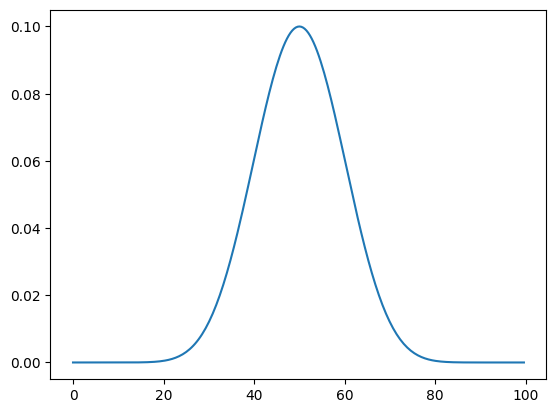

In [4]:
# Creating the mesh and initial condition
mesh = jnp.linspace(0.0, DOMAIN_SIZE, NUM_DOF, endpoint=False)

# creating an array of u_0 with the same shape as the mesh of senoidal values
u_0 = 0.1*jnp.sin(1 * jnp.pi * mesh / DOMAIN_SIZE)**10
#plotting the initial condition
plt.plot(mesh, u_0)

## Executing the ETDRK2 Method

In this version of nootebook we will create an dataset based on the same dimention of the original paper worked. However we will create a vector corresponding to the $\nu$ parameter to be used on the hypernetwork.


In [5]:
ks_stepper_etdrk2 = KsEtd2(
    L=DOMAIN_SIZE,
    N=NUM_DOF,
    dt=DT,
    nu=0.6,
)

ks_stepper_etdrk2 = jax.jit(ks_stepper_etdrk2)

In [6]:
u_current = u_0
trj_etdrk2 = [u_current]
for i in range(4001):
    u_current = ks_stepper_etdrk2(u_current)
    trj_etdrk2.append(u_current)

trj_etdrk2 = jnp.stack(trj_etdrk2)

Text(0, 0.5, 'space')

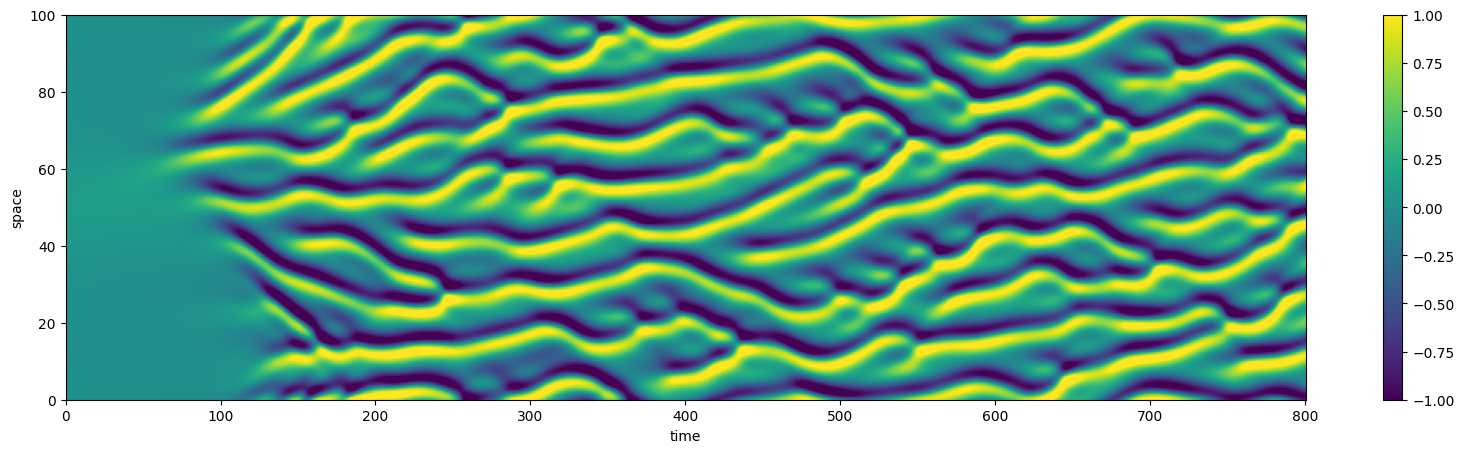

In [8]:
plt.figure(figsize=(20, 5))
plt.imshow(
    trj_etdrk2.T,
    cmap="viridis",
    aspect="auto",
    origin="lower",
    extent=(0, trj_etdrk2.shape[0] * DT, 0, DOMAIN_SIZE),
    vmin=-1,
    vmax=1,
)
plt.colorbar()
plt.xlabel("time")
plt.ylabel("space")

## Creating the Dataset

In [83]:
ks_etdrk2_stepper = KsEtd2(DOMAIN_SIZE, NUM_DOF, DT, nu = 1.0)

ks_etdrk2_operators = [KsEtd2(DOMAIN_SIZE, NUM_DOF, DT, nu = value) for value in jnp.linspace(0.1, 1.2, OPERATOR_PKG_SIZE)]

In [84]:
u_0 = jax.random.normal(jax.random.PRNGKey(0), (NUM_SAMPLES_TRAIN,1,NUM_DOF))

u_0 = jax.vmap(lambda u: u - jnp.mean(u))(u_0)

u_0.shape

(60, 1, 256)

In [85]:
def rollout(
        stepper_fn,
        n,
        *,
        include_init = False,
    ):

    """Transform an autonomous timestepper into a function that efficiently unrolls a trajectory."""
    def scan_fn(u, _):
        u_next = stepper_fn(u)
        return u_next, u_next

    def rollout_fn(init):
        _,history = jax.lax.scan(scan_fn, init, None, length=n)

        if include_init:
            return jnp.concatenate([init[None], history], axis=0)
        else:
            return history
    
    return rollout_fn
    

# def slice_window_of_tow(trjs):
#     batch_size_1, batch_size_2, num_time_steps,_  = trjs.shape

#     windows = []

#     for i in range(batch_size_2 - 1):  # Ajustar para janelas ao longo da segunda dimensão
#         windows.append(trjs[:, i:i+2])  # Criando as janelas de tamanho 2 ao longo da segunda dimensão

#     return jnp.stack(windows, axis=1)

def slice_window_of_tow(one_trj):
    num_time_steps = one_trj.shape[0]

    windows = []

    for i in range(num_time_steps- 1):
        windows.append(one_trj[i:i+2]) # This part of the code make the windows of size 2

    return jnp.stack(windows)



In [86]:
trj_with_warmpu = jax.vmap(rollout(ks_etdrk2_stepper, TRAIN_TEMPORAL_HORIZON + NUM_WARMUP_STEPS, include_init=True))(u_0)

trj_with_warmpu = []
for i in range(OPERATOR_PKG_SIZE):
    trj_temp = jax.vmap(rollout(ks_etdrk2_operators[i], TRAIN_TEMPORAL_HORIZON + NUM_WARMUP_STEPS, include_init=True))(u_0) 
    trj_temp = trj_temp[:,NUM_WARMUP_STEPS:,:,:]
    
    # Apeend the trj_temp to the trj_with_warmpu to create a new dimension resulting in  (OPERATOR_PKG_SIZE, NUM_SAMPLES_TRAIN, TRAIN_TEMPORAL_HORIZON + NUM_WARMUP_STEPS, NUM_DOF)
    trj_with_warmpu.append(trj_temp)

# trj_with_warmpu = jnp.array(trj_with_warmpu)
trj_with_warmpu[0].shape

(60, 101, 1, 256)

In [87]:
trj = []
for i in range(OPERATOR_PKG_SIZE):
    trj.append(jax.vmap(slice_window_of_tow)(trj_with_warmpu[i]))

trj = jnp.array(trj)
trj.shape

(50, 60, 100, 2, 1, 256)

In [88]:
trj_final = []
for i in range(OPERATOR_PKG_SIZE):
    trj_final.append(jnp.concatenate(trj[i], axis=0))


trj_final = jnp.array(trj_final)

trj_final = jnp.concatenate(trj_final, axis=0)
trj_final.shape

(300000, 2, 1, 256)

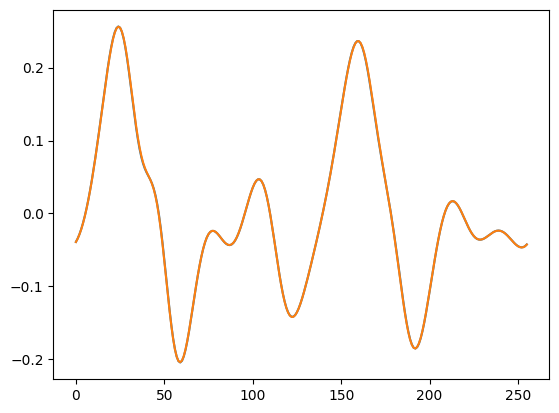

In [93]:
plt.plot(trj_final[40110,:,1,:].T)

In [96]:
#Creating jnp.linspace(0.1, 1.2, OPERATOR_PKG_SIZE) vector 
arr = jnp.linspace(0.1, 1.2, OPERATOR_PKG_SIZE)

# Repetir cada elemento 3000 vezes
expanded_arr = jnp.repeat(arr, 6000)

In [97]:
expanded_arr.shape

(300000,)

In [98]:
def dataloader(
    targuet_data,
    hyper_targuet_data,
    *,
    batch_size: int,
    key,
):
    """
    Loop generator over the targuet_data. The targuet_data can be a PyTree or an Array. For
    supervised learning problems you can also hand over a tuple of Arrays
    (=PyTree).
    """

    n_samples_list = [a.shape[0] for a in jtu.tree_leaves(targuet_data)]

    if not all(n == n_samples_list[0] for n in n_samples_list):
        raise ValueError(
            "All arrays / PyTree leaves must have the same number of samples. (Leading array axis)"
        )

    n_samples = n_samples_list[0]

    n_batches = int(jnp.ceil(n_samples / batch_size))

    permutation = jax.random.permutation(key, n_samples)

    for batch_id in range(n_batches):
        start = batch_id * batch_size
        end = min((batch_id + 1) * batch_size, n_samples)

        batch_indices = permutation[start:end]

        sub_targuet_data = jtu.tree_map(lambda a: a[batch_indices], targuet_data)
        sub_hyper_targuet_data = jtu.tree_map(lambda a: a[batch_indices], hyper_targuet_data)

        yield sub_hyper_targuet_data,sub_targuet_data

In [99]:
import jax 
import jax.numpy as jnp
from jax import random
from jax import grad, jit, vmap
import flax 
from flax import linen as nn
from functools import partial
from jax.flatten_util import ravel_pytree
from typing import List


import jax.tree_util as jtu
import matplotlib.pyplot as plt
import equinox as eqx
import optax
from tqdm.autonotebook import tqdm

from typing import Callable

class ResBlockPostActivationPeriodic1d(eqx.Module):
    conv_1: eqx.nn.Conv1d # This is the first convolutional layer
    conv_2: eqx.nn.Conv1d # This is the second convolutional layer
    activation: Callable # This is the activation function, and the Callable type is a function that returns a value

    def __init__(
        self,
        hidden_channels: int,
        activation: Callable,
        *, # This is a separator to indicate that the following arguments are keyword-only
        key,
    ):
        c_1_key, c_2_key = jax.random.split(key)

        # Requires an up-to-dat version of Equinox
        self.conv_1 = eqx.nn.Conv1d( # This is the first convolutional layer
            hidden_channels, # This is the number of input channels
            hidden_channels, # This is the number of output channels
            kernel_size=3, # This is the kernel size, it means that the convolutional layer will use 3 points to make the convolution
            padding="SAME", # This is the padding, it means that the convolutional layer will use the same size of the input
            padding_mode="CIRCULAR", # This is the padding mode, it means that the convolutional layer will use the circular padding
            key=c_1_key 
        )
        self.conv_2 = eqx.nn.Conv1d(
            hidden_channels,
            hidden_channels,
            kernel_size=3,
            padding="SAME",
            padding_mode="CIRCULAR",
            key=c_2_key
        )

        self.activation = activation

    def __call__(
        self,
        x,
    ):
        x_skip_1 = x
        x = self.conv_1(x)
        x = x + x_skip_1 # Residual connection
        x = self.activation(x)
        x_skip_2 = x
        x = self.conv_2(x)
        x = x + x_skip_2 # Residual connection
        x = self.activation(x)

        return x
    
    def get_params(self):
        return [self.conv_1.weight,
                self.conv_1.bias, 
                self.conv_2.weight, 
                self.conv_2.bias]


from typing import Callable
class ResNetPeriodic1d(eqx.Module):
    lifting: eqx.nn.Conv1d # This is the first layer, the lifting layer that maps the input to the hidden space of the network with upper dimension
    blocks: list[ResBlockPostActivationPeriodic1d] # This is the list of the ResNet blocks that will be used in the network.
    projection: eqx.nn.Conv1d # This is another 1D convolutional layer with kernel size 1, which projects the final transformed data back to a lower-dimensional space.

    def __init__(
        self,
        hidden_channels,
        num_blocks,
        activation,
        *,
        key,
    ):
        l_key, *block_keys, p_key = jax.random.split(key, num_blocks+2)

        self.lifting = eqx.nn.Conv1d(1, hidden_channels, kernel_size=1, key=l_key)
        self.blocks = [
            ResBlockPostActivationPeriodic1d(hidden_channels, activation, key=k)
            for k in block_keys
        ]
        self.projection = eqx.nn.Conv1d(hidden_channels, 1, kernel_size=1, key=p_key)

    def __call__(self, x):
        x = self.lifting(x)
        for block in self.blocks:
            x = block(x)
        x = self.projection(x)

        return x
    
    def get_params_tree(self):
        # Retorna os parâmetros das camadas
        lifting_params = [
            self.lifting.weight,
            self.lifting.bias
        ]

        block_params = [block.get_params() for block in self.blocks]
        
        projection_params = [
            self.projection.weight,
            self.projection.bias
            ]

        return [
            lifting_params,
            block_params,
            projection_params
        ]
    
    def set_params(self, params):
        # Update lifting layer
        self = eqx.tree_at(lambda m: m.lifting.weight, self, params[0][0])
        self = eqx.tree_at(lambda m: m.lifting.bias, self, params[0][1])

        # Update ResBlocks
        for i, block in enumerate(self.blocks):
            self = eqx.tree_at(lambda m: m.blocks[i].conv_1.weight, self, params[1][i][0])
            self = eqx.tree_at(lambda m: m.blocks[i].conv_1.bias, self, params[1][i][1])
            self = eqx.tree_at(lambda m: m.blocks[i].conv_2.weight, self, params[1][i][2])
            self = eqx.tree_at(lambda m: m.blocks[i].conv_2.bias, self, params[1][i][3])

        # Update projection layer
        self = eqx.tree_at(lambda m: m.projection.weight, self, params[2][0])
        self = eqx.tree_at(lambda m: m.projection.bias, self, params[2][1])

        return self
    
    def get_num_params(self):
        return sum([p.size for p in jax.tree.flatten(self.get_params_tree())[0]])


class HyperNet(eqx.Module):
    layers: List[eqx.nn.Linear]

    def __init__(
        self,
        layers_size = [],
        last_layer_size = None,
        key = None,
    ):
        self.layers = []
        for (fan_in, fan_out) in zip(layers_size[:-1], layers_size[1:]):
            key, subkey = jax.random.split(key)
            self.layers.append(eqx.nn.Linear(fan_in, fan_out, key=subkey, use_bias=True))
        
        self.layers.append(eqx.nn.Linear(layers_size[-1], last_layer_size, key=subkey, use_bias=True))

    def __call__(self, x):
        for layer in self.layers[:-1]: # Iterate over all layers except the last one
            x = jax.nn.relu(layer(x))
            # the last layer must not have an activation function in addition the output must have the last_layer_size shape
        return self.layers[-1](x)
    
    def get_params(self):
        return [[layer.weight] + [layer.bias] for layer in self.layers]
    

#create a class that inherits from the HyperNet and ResNetPeriodic1d

class HyperResidualRNN(eqx.Module):
    hypernet: HyperNet
    targetnet: ResNetPeriodic1d
    def __init__(self, hypernet, targetnet):
        self.hypernet = hypernet
        self.targetnet = targetnet

        # Get the parameters for the targetnet
    def get_unravel(self):
        targetnet_params = self.targetnet.get_params_tree()
        # Get the unravelling function for the targetnet
        _,unravel = ravel_pytree(targetnet_params)
        return unravel

    def __call__(self, input_target, input_hyper, unravel_fn):
        # Calculate the output of the hypernet
        input_hyper = self.hypernet(input_hyper)

        # Unravel the parameters
        targetnet_params = unravel_fn(input_hyper)

        # Set the parameters of the targetnet
        self.targetnet.set_params(targetnet_params)

        input_target = jax.vmap(self.targetnet)(input_target)

        return input_target
        



In [103]:

# Definindo variáveis
HIDDEN_CHANNELS = 10
NUM_BLOCKS = 15
ACTIVATION = jax.nn.relu
INIT_SEED = 42
LEARNING_RATE = 1e-4
SHUFFLE_SEED = 99
NUM_EPOCHS = 3
BATCH_SIZE = 40
LAYERS = [1,20,20]

# Create the key
key = jax.random.PRNGKey(INIT_SEED)

# Create the TargetNet
targetnet = ResNetPeriodic1d(HIDDEN_CHANNELS, NUM_BLOCKS, jax.nn.relu, key=key)
targetnet_num_params = targetnet.get_num_params()

# Create the HyperNet
hypernet = HyperNet(LAYERS,last_layer_size = targetnet_num_params, key=key)


# Create the HyperResidualRNN
model = HyperResidualRNN(hypernet, targetnet)
unravel = model.get_unravel()

optimizer = optax.adam(LEARNING_RATE)

opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

# Creating the loss function
@eqx.filter_jit
def loss_fn(model, batch, unravel):

    input_hyper = jnp.expand_dims(batch[0][1], axis=0)
    input_target = batch[1][:,0]
    targets = batch[1][:,1]

    predictions = model(input_target, input_hyper, unravel)
    return jnp.mean((predictions - targets) ** 2)

# Função de atualização do modelo
@eqx.filter_jit
def step_fn(model, state, batch,unravel):
    unravel = unravel
    loss, grad = eqx.filter_value_and_grad(loss_fn)(model, batch, unravel)
    updates, new_state = optimizer.update(grad, state, model)
    new_model = eqx.apply_updates(model, updates)
    return new_model, new_state, loss



In [101]:
# Create the dataloader
batch = next(dataloader(trj_final, expanded_arr, batch_size=20, key=jax.random.PRNGKey(0)))

# testing the loss function
if loss_fn(model, batch, unravel): 
    print("The loss function is working properly")

# testing the step function
if step_fn(model, opt_state, batch, unravel):
    print("The step function is working properly")

The loss function is working properly
The step function is working properly


In [102]:
# Tentativa de fluxo de dados na HRN com o dataloader

batch = next(dataloader(trj_final, expanded_arr, batch_size=10, key=jax.random.PRNGKey(1)))

hyper_output = hypernet(jnp.expand_dims(batch[0][1], axis=0))

target_params = unravel(hyper_output)

targetnet.set_params(target_params)

target_output = jax.vmap(targetnet)((batch[1][:,0]))

loss = jnp.mean((target_output - batch[1][:,1])**2)
print(loss)
# fazer o backpropagation para atualizar os parâmetros da hyperrede


45.337543


In [106]:
# Inicializando variáveis de histórico
shuffle_key = jax.random.PRNGKey(SHUFFLE_SEED)
train_loss_history = []
param_history = []  # Para armazenar o histórico dos parâmetros achatados

# Loop de treinamento
for epoch in tqdm(range(NUM_EPOCHS)):
    shuffle_key, subkey = jax.random.split(shuffle_key)

    for batch in tqdm(dataloader(trj_final,expanded_arr , batch_size=BATCH_SIZE, key=subkey)):
        model, opt_state, loss = step_fn(model, opt_state, batch, unravel)

        # Salvar a perda do treinamento
        train_loss_history.append(loss)

    print('Avg Loss: ', jnp.min(loss))

4048it [09:31,  7.08it/s]00<?, ?it/s]
  0%|          | 0/3 [09:31<?, ?it/s]


KeyboardInterrupt: 

Text(0, 0.5, 'Loss')

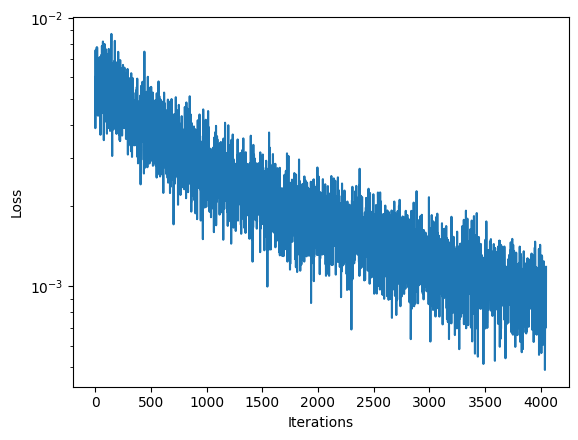

In [107]:
plt.semilogy(train_loss_history)
plt.xlabel('Iterations')
plt.ylabel('Loss')